In [1]:
# !pip install mlxtend
# !pip install numpy scipy pandas scikit-learn
# !pip install seaborn

In [19]:
import kagglehub
import numpy as np 
import cv2
import glob
import os
import matplotlib.pyplot as plt
import string
import warnings
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.utils.multiclass import unique_labels
from sklearn import metrics
from sklearn.svm import SVC
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from skimage.feature import hog
from skimage import color
import seaborn as sns
import pandas as pd
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

In [3]:

path = kagglehub.dataset_download("moltean/fruits")

print("Path to dataset files:", path)
img_size = (100, 100)
batch_size = 32

base_path = os.path.join(path, "fruits-360_dataset_100x100", "fruits-360")
train_dir = os.path.join(base_path, "Training")
test_dir = os.path.join(base_path, "Test")


Path to dataset files: C:\Users\raduf\.cache\kagglehub\datasets\moltean\fruits\versions\11


In [4]:
# Generatoare de date
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 70491 images belonging to 141 classes.
Found 23619 images belonging to 141 classes.


In [5]:
X_train = np.concatenate([train_generator[i][0] for i in range(len(train_generator))], axis=0)
X_test = np.concatenate([test_generator[i][0] for i in range(len(test_generator))], axis=0)
images, labels = train_generator[0]
class_names = list(train_generator.class_indices.keys())


In [6]:
Y_train = np.concatenate([train_generator[i][1] for i in range(len(train_generator))], axis=0)
Y_test = np.concatenate([test_generator[i][1] for i in range(len(test_generator))], axis=0)

In [7]:
Y_train_decimal = np.argmax(Y_train, axis=1)
Y_test_decimal = np.argmax(Y_test, axis=1)

In [8]:
pca = PCA(n_components=10)

X_test_flat = X_test.reshape(X_test.shape[0], -1)

X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_train_pca = pca.fit_transform(X_train_flat)

X_test_pca = pca.transform(X_test_flat)

In [9]:
def extract_hog_features(images):
    hog_features = []
    for img in images:
        features, _ = hog(color.rgb2gray(img), orientations=6, pixels_per_cell=(16, 16),
                          cells_per_block=(1, 1), block_norm='L2-Hys', visualize=True)
        hog_features.append(features)
    return np.array(hog_features)

X_test_hog = extract_hog_features(X_test)


In [10]:
X_train_hog = extract_hog_features(X_train)

## 4.2

<Figure size 2000x800 with 0 Axes>

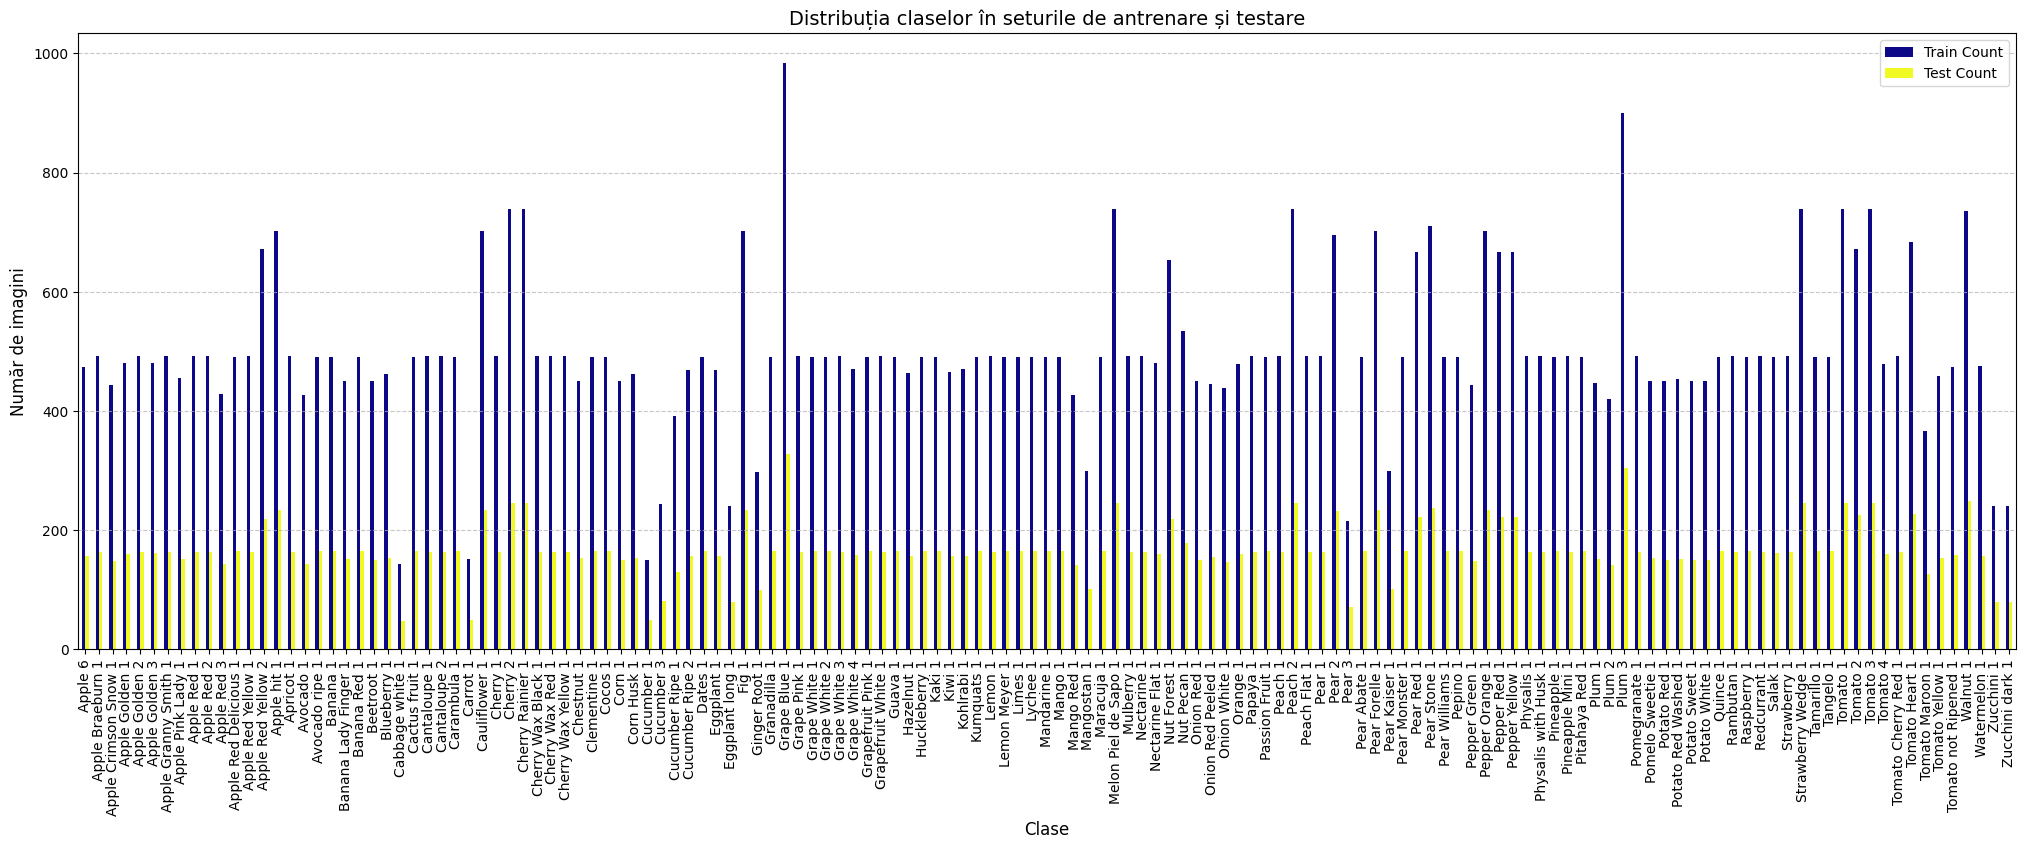

In [11]:
class_names = list(train_generator.class_indices.keys())

df_train = pd.DataFrame({'Label': train_generator.classes})
df_test = pd.DataFrame({'Label': test_generator.classes})

combined_df = pd.DataFrame({
    'Class': class_names,
    'Train Count': df_train['Label'].value_counts().sort_index().values,
    'Test Count': df_test['Label'].value_counts().sort_index().values
})

plt.figure(figsize=(20, 8))
combined_df.set_index('Class').plot(kind='bar', colormap='plasma', figsize=(25, 8))
plt.xticks(rotation=90, fontsize=10)
plt.title('Distribuția claselor în seturile de antrenare și testare', fontsize=14)
plt.xlabel('Clase', fontsize=12)
plt.ylabel('Număr de imagini', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [12]:
top_10_classes = combined_df.sort_values(by='Train Count', ascending=False).head(10)['Class'].values

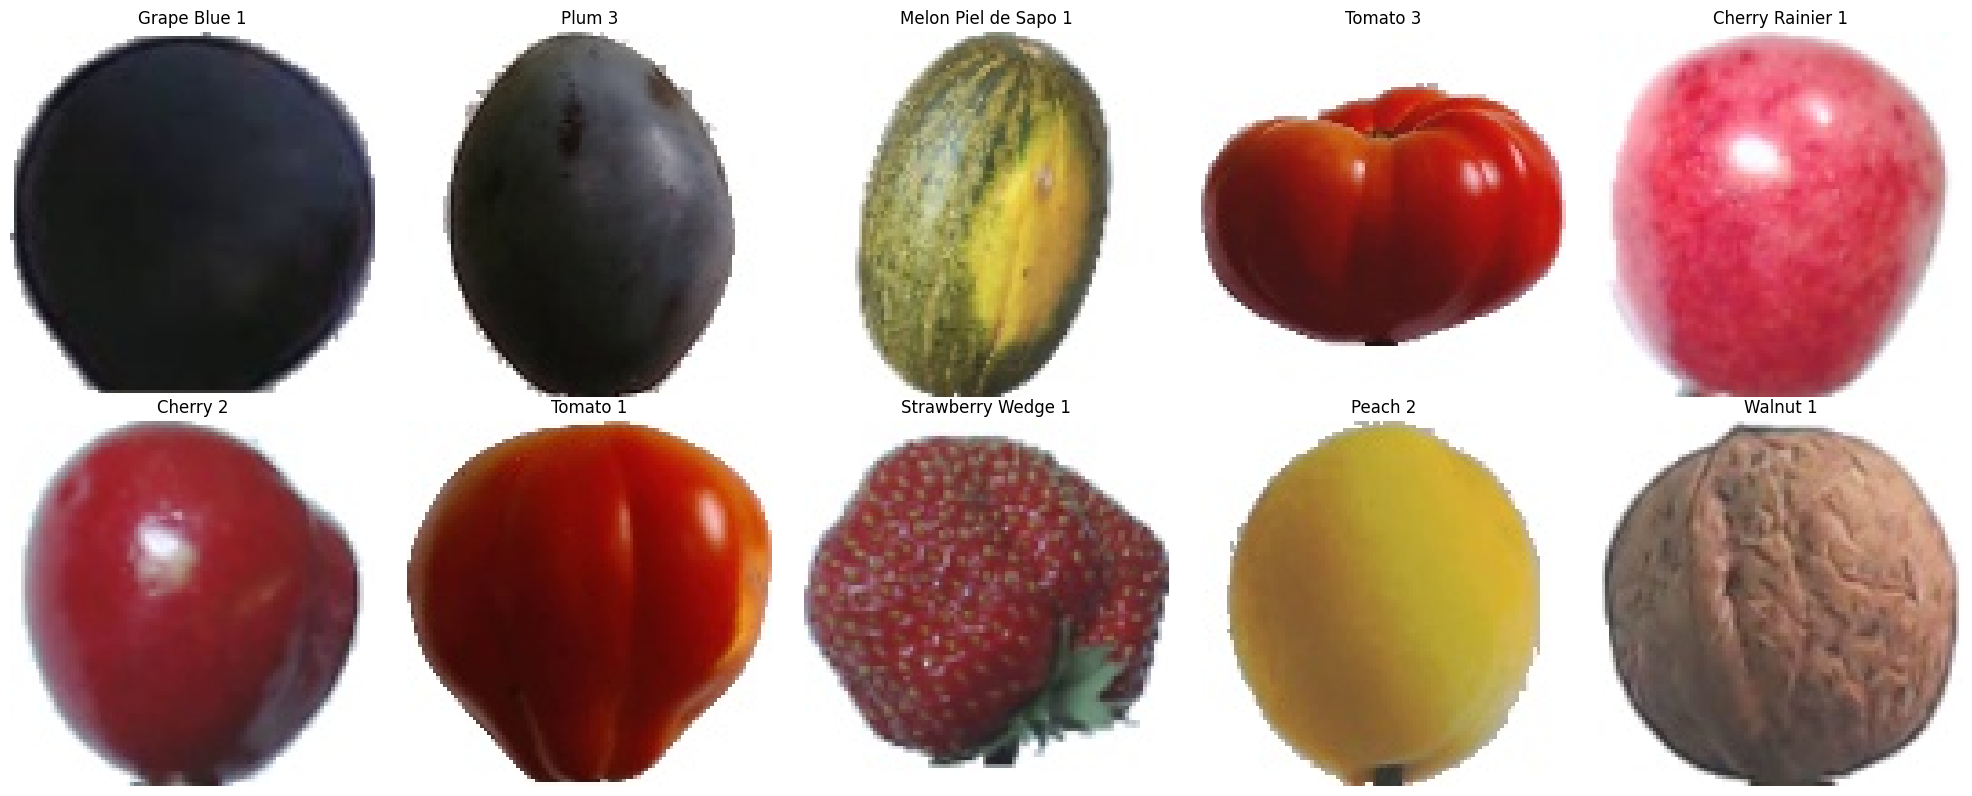

Indici imagini selectate: [(750, 19, 51), (1730, 29, 112), (1123, 3, 75), (2034, 20, 130), (485, 2, 32), (462, 0, 31), (1990, 18, 128), (1936, 28, 125), (1331, 23, 88), (2150, 1, 137)]


In [ ]:
image_indices = []
original_images = []

fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.flatten()

for i, class_name in enumerate(top_10_classes):
    class_index = class_names.index(class_name)
    for batch_index in range(len(train_generator)):
        images, labels = train_generator[batch_index]  
        class_indices = np.where(labels[:, class_index] == 1)[0]
        if len(class_indices) > 0:
            img = images[class_indices[0]]
            image_indices.append((batch_index, class_indices[0], class_index))
            original_images.append(img)
            axes[i].imshow(img)
            axes[i].set_title(class_name)
            axes[i].axis('off')
            break

plt.tight_layout()
plt.show()

print("Indici imagini selectate:", image_indices)



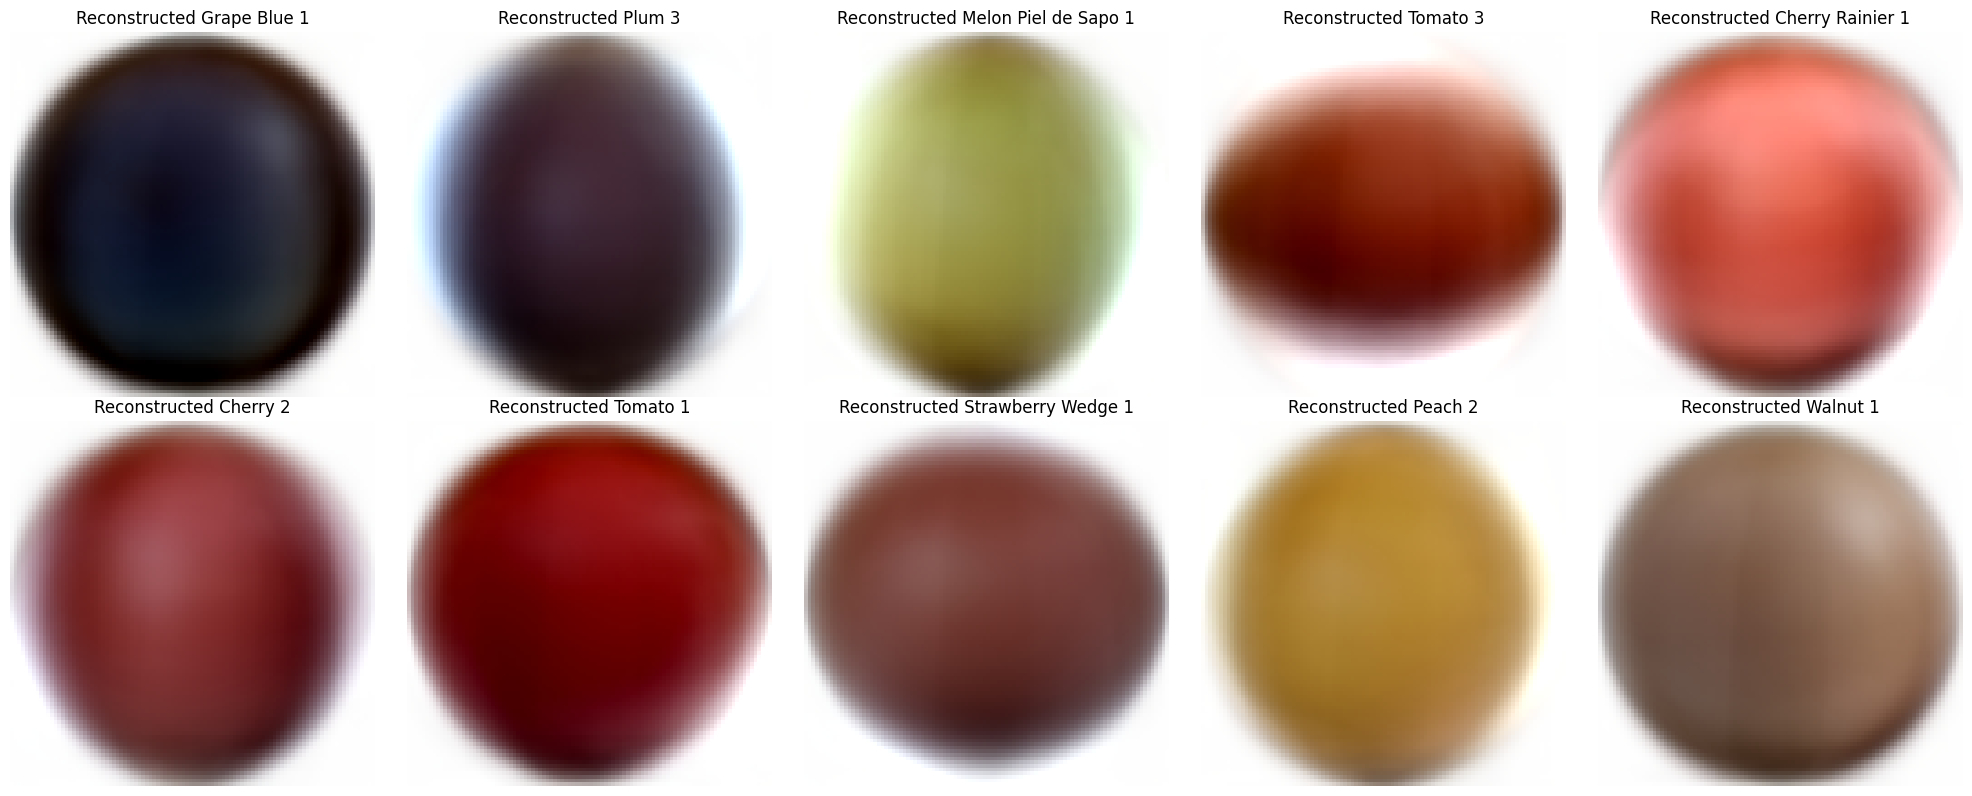

In [14]:

reconstructed_images = []
for idx in image_indices:
    global_index = len(train_generator[0][0]) * idx[0] + idx[1]
    img_reconstructed = pca.inverse_transform(X_train_pca[global_index]).reshape(*img_size, 3)
    reconstructed_images.append(img_reconstructed)

fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.flatten()

for i, img_reconstructed in enumerate(reconstructed_images):
    axes[i].imshow(img_reconstructed.clip(0, 1))  # Clip pentru valori valide
    axes[i].set_title(f'Reconstructed {class_names[image_indices[i][2]]}')  # Numele clasei
    axes[i].axis('off')

plt.tight_layout()
plt.show()


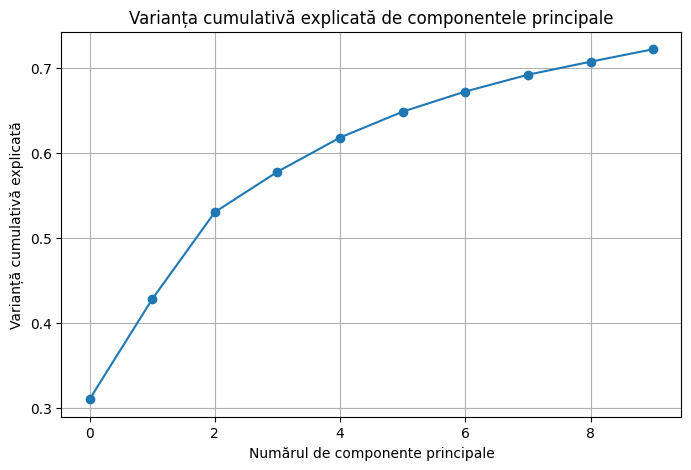

In [15]:

img_size = (100, 100)
plt.figure(figsize=(8, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.title("Varianța cumulativă explicată de componentele principale")
plt.xlabel("Numărul de componente principale")
plt.ylabel("Varianță cumulativă explicată")
plt.grid()
plt.show()

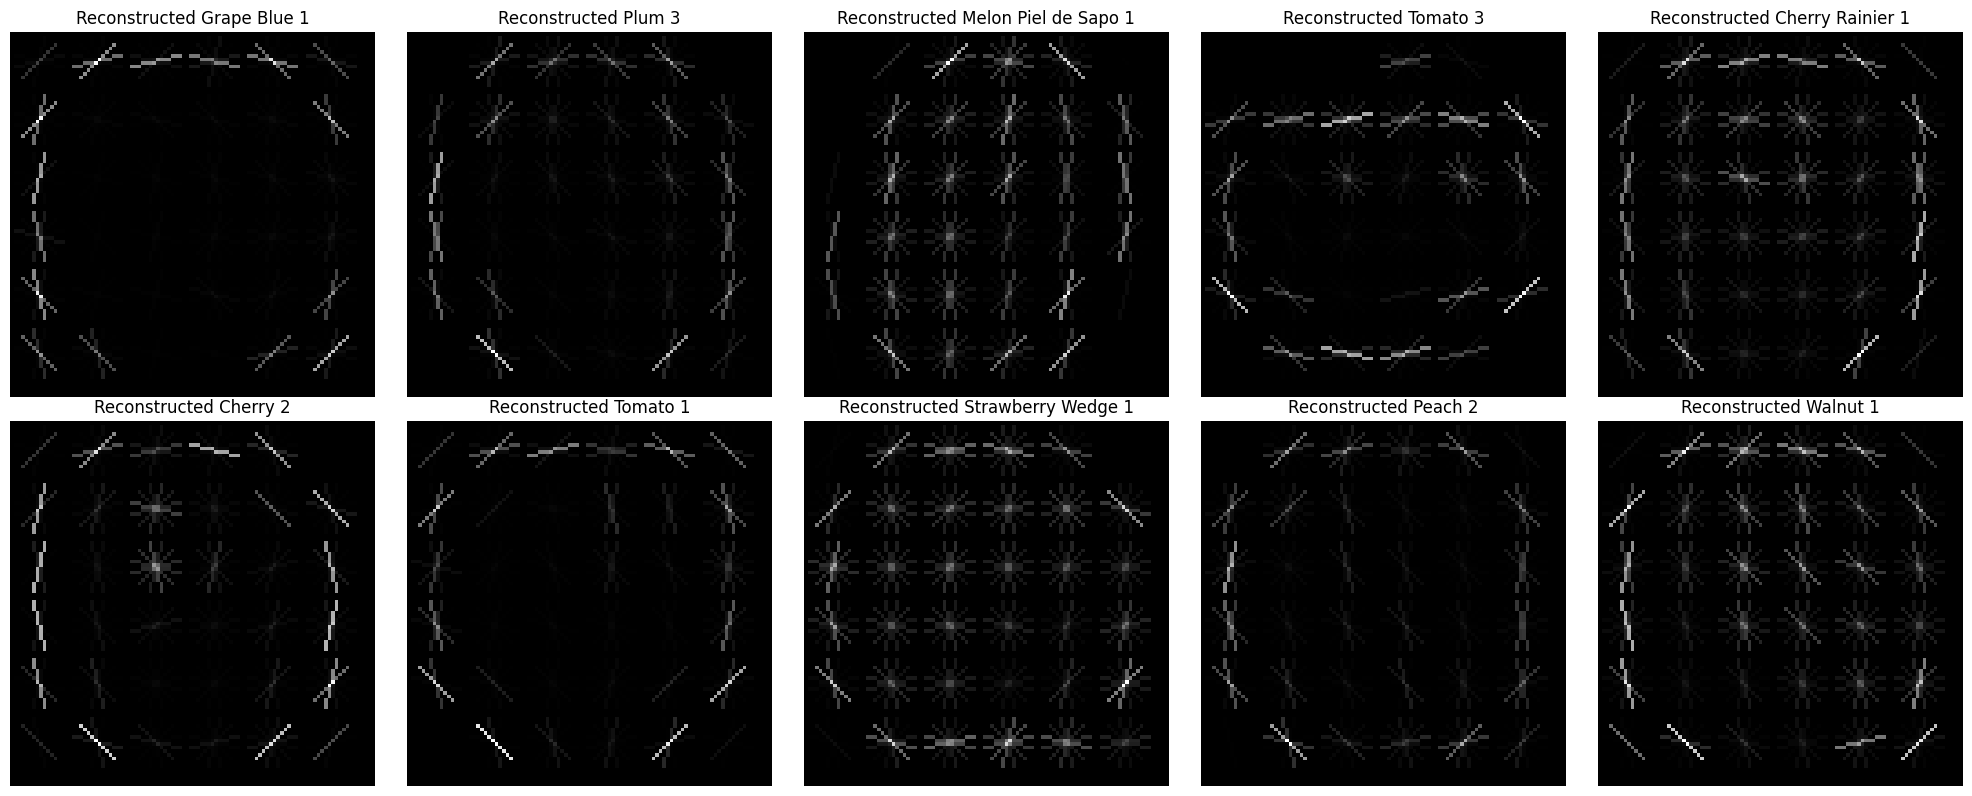

In [16]:
hog_images_list = []

for img in original_images:
    _, hog_image = hog(color.rgb2gray(img), orientations=6, pixels_per_cell=(16, 16),
                          cells_per_block=(1, 1), block_norm='L2-Hys', visualize=True)
    hog_images_list.append(hog_image)

fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.flatten()

for i, hog_image in enumerate(hog_images_list):
    axes[i].imshow(hog_image, cmap='gray')
    axes[i].set_title(f'Reconstructed {class_names[image_indices[i][2]]}')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

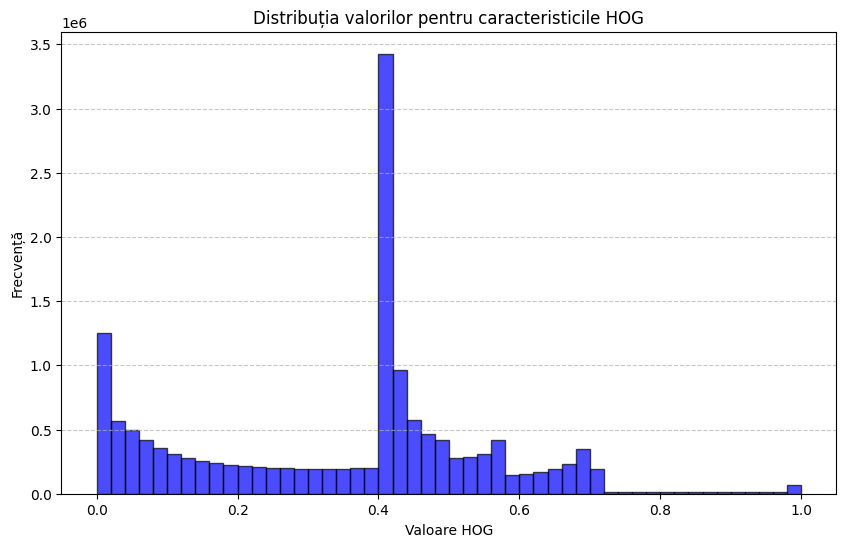

In [17]:

hog_feature_values = X_train_hog.flatten()
plt.figure(figsize=(10, 6))
plt.hist(hog_feature_values, bins=50, color='blue', edgecolor='black', alpha=0.7)
plt.title("Distribuția valorilor pentru caracteristicile HOG")
plt.xlabel("Valoare HOG")
plt.ylabel("Frecvență")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [18]:
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold, SelectPercentile, f_classif

scaler = StandardScaler()

scaler.fit(X_train_pca)

x_train_pca_standardized = scaler.transform(X_train_pca)

x_test_pca_standardized = scaler.transform(X_test_pca)


scaler_hog = StandardScaler()
x_train_hog_standardized = scaler_hog.fit_transform(X_train_hog)
x_test_hog_standardized = scaler_hog.transform(X_test_hog)

x_train_combined = np.hstack((x_train_pca_standardized, x_train_hog_standardized))
x_test_combined = np.hstack((x_test_pca_standardized, x_test_hog_standardized))

variance_threshold = VarianceThreshold(threshold=1)
x_train_variance = variance_threshold.fit_transform(x_train_combined)
x_test_variance = variance_threshold.transform(x_test_combined)

print("Dimensiuni înainte și după Variance Threshold:")
print(f"Dimensiuni train înainte: {x_train_combined.shape}, după: {x_train_variance.shape}")
print(f"Dimensiuni test înainte: {x_test_combined.shape}, după: {x_test_variance.shape}")

Dimensiuni înainte și după Variance Threshold:
Dimensiuni train înainte: (70491, 226), după: (70491, 110)
Dimensiuni test înainte: (23619, 226), după: (23619, 110)


## LogisticRegression

In [ ]:
warnings.filterwarnings("ignore")

log_reg = LogisticRegression(max_iter=150)

param_grid = {
    "C": [0.1, 1, 10, 100],
    "multi_class": ["ovr", "multinomial"]
}
# best_param_grid = {
#     "C": [10],
#     "multi_class": ["multinomial"]
# }

random_search = RandomizedSearchCV(log_reg, param_grid, cv=5, n_iter=10, random_state=42)

random_search.fit(x_train_variance, Y_train_decimal)

best_model = random_search.best_estimator_
best_params = random_search.best_params_

y_pred_combined = best_model.predict(x_test_variance)

accuracy_combined = accuracy_score(Y_test_decimal, y_pred_combined)
report_combined = classification_report(Y_test_decimal, y_pred_combined, target_names=class_names)

print(f"Cei mai buni hiper-parametri: {best_params}")
print(f"Accuracy (Combined PCA + HOG): {accuracy_combined}")
print("Classification Report (Combined PCA + HOG):")
print(report_combined)

precision_scores = precision_score(Y_test_decimal, y_pred_combined, average=None)
mean_precision = np.mean(precision_scores)
var_precision = np.var(precision_scores)

print(f"Mean Precision: {mean_precision}")
print(f"Variance of Precision: {var_precision}")

In [ ]:
selected_classes = [class_names[idx[2]] for idx in image_indices]

selected_indices = np.isin(Y_test_decimal, [idx[2] for idx in image_indices])
filtered_y_test = Y_test_decimal[selected_indices]
filtered_y_pred = y_pred_combined[selected_indices]

cm_selected = confusion_matrix(filtered_y_test, filtered_y_pred, labels=[idx[2] for idx in image_indices])

plt.figure(figsize=(10, 10), dpi=300)
sns.heatmap(cm_selected, annot=True, fmt='d', cmap='viridis', xticklabels=selected_classes, yticklabels=selected_classes)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for Selected Classes")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


## SVC

In [ ]:
from sklearn.svm import SVC

svm_model = SVC()

param_grid_svm = {
    "C": [0.1, 1, 10, 100],
    "kernel": ["linear", "rbf", "poly"], 
}

# cei mai buni hiper-parametri
# param_grid_svm = {
#     "C": [1],
#     "kernel": ["linear"], 
# }

random_search_svm = RandomizedSearchCV(
    svm_model,
    param_distributions=param_grid_svm,
    cv=5,
    n_iter=10,
    random_state=42,
    scoring="accuracy",
    verbose=0
)

random_search_svm.fit(x_train_variance, Y_train_decimal)

best_svm_model = random_search_svm.best_estimator_
best_svm_params = random_search_svm.best_params_

y_pred_svm = best_svm_model.predict(x_test_variance)

accuracy_svm = accuracy_score(Y_test_decimal, y_pred_svm)
report_svm = classification_report(Y_test_decimal, y_pred_svm, target_names=class_names)

print(f"Cei mai buni hiper-parametri SVM: {best_svm_params}")
print(f"Accuracy SVM (Combined PCA + HOG): {accuracy_svm}")
print("Classification Report SVM (Combined PCA + HOG):")
print(report_svm)
precision_scores = precision_score(Y_test_decimal, y_pred_svm, average=None)
mean_precision = np.mean(precision_scores)
var_precision = np.var(precision_scores)

print(f"Mean Precision: {mean_precision}")
print(f"Variance of Precision: {var_precision}")


In [ ]:
selected_classes = [class_names[idx[2]] for idx in image_indices]

selected_indices = np.isin(Y_test_decimal, [idx[2] for idx in image_indices])
filtered_y_test = Y_test_decimal[selected_indices]
filtered_y_pred = y_pred_svm[selected_indices]

cm_selected = confusion_matrix(filtered_y_test, filtered_y_pred, labels=[idx[2] for idx in image_indices])

plt.figure(figsize=(10, 10), dpi=300)
sns.heatmap(cm_selected, annot=True, fmt='d', cmap='viridis', xticklabels=selected_classes, yticklabels=selected_classes)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for Selected Classes")
plt.xticks(rotation=90) 
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## RandomForestClassifier

In [ ]:
# # i43 de minute
from sklearn.ensemble import RandomForestClassifier


rf_model = RandomForestClassifier(random_state=42)

param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, 30, None],
    'max_samples': [0.5, 0.75, 1.0]
}

# cei mai buni hiper-parametri
# param_grid_rf = {
#     'n_estimators': [200],
#     'max_depth': [None],
#     'max_samples': [1.0]
# }

random_search_rf = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=param_grid_rf,
    n_iter=10,
    scoring="accuracy",
    cv=5,
    verbose=0,
    random_state=42
)

random_search_rf.fit(x_train_variance, Y_train_decimal)

best_rf_model = random_search_rf.best_estimator_
best_rf_params = random_search_rf.best_params_

y_pred_rf = best_rf_model.predict(x_test_variance)

accuracy_rf = accuracy_score(Y_test_decimal, y_pred_rf)
report_rf = classification_report(Y_test_decimal, y_pred_rf, target_names=class_names)

print(f"Cei mai buni hiper-parametri Random Forest: {best_rf_params}")
print(f"Accuracy Random Forest (Combined PCA + HOG): {accuracy_rf}")
print("Classification Report Random Forest:")
print(report_rf)


precision_scores = precision_score(Y_test_decimal, y_pred_rf, average=None)
mean_precision = np.mean(precision_scores)
var_precision = np.var(precision_scores)

print(f"Mean Precision: {mean_precision}")
print(f"Variance of Precision: {var_precision}")


In [ ]:
selected_classes = [class_names[idx[2]] for idx in image_indices]

selected_indices = np.isin(Y_test_decimal, [idx[2] for idx in image_indices])
filtered_y_test = Y_test_decimal[selected_indices]
filtered_y_pred = y_pred_rf[selected_indices]

cm_selected = confusion_matrix(filtered_y_test, filtered_y_pred, labels=[idx[2] for idx in image_indices])

plt.figure(figsize=(10, 10), dpi=300)
sns.heatmap(cm_selected, annot=True, fmt='d', cmap='viridis', xticklabels=selected_classes, yticklabels=selected_classes)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for Selected Classes")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


## GradientBoosted Trees

In [ ]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(random_state=42, eval_metric="logloss", tree_method="hist", device="cuda")


param_grid_xgb = {
    'n_estimators': [50, 150, 200],
    'max_depth': [3, 6, 10], 
    'learning_rate': [0.01, 0.1, 0.2]
}
# cei mai buni hiper-parametri
# param_grid_xgb = {
#     'n_estimators': [200],
#     'max_depth': [6], 
#     'learning_rate': [0.1]
# }


random_search_xgb = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_grid_xgb,
    scoring="accuracy",
    cv=5,
    random_state=42
)

random_search_xgb.fit(x_train_variance, Y_train_decimal)

best_xgb_model = random_search_xgb.best_estimator_
best_xgb_params = random_search_xgb.best_params_

y_pred_xgb = best_xgb_model.predict(x_test_variance)

accuracy_xgb = accuracy_score(Y_test_decimal, y_pred_xgb)
report_xgb = classification_report(Y_test_decimal, y_pred_xgb, target_names=class_names)

print(f"Cei mai buni hiper-parametri XGBClassifier: {best_xgb_params}")
print(f"Accuracy XGBClassifier: {accuracy_xgb}")
print("Classification Report XGBClassifier:")
print(report_xgb)

ConfusionMatrixDisplay.from_estimator(best_xgb_model, x_test_variance, Y_test_decimal, display_labels=class_names)

precision_scores = precision_score(Y_test_decimal, y_pred_xgb, average=None)
mean_precision = np.mean(precision_scores)
var_precision = np.var(precision_scores)

print(f"Mean Precision: {mean_precision}")
print(f"Variance of Precision: {var_precision}")


In [ ]:

selected_classes = [class_names[idx[2]] for idx in image_indices]

selected_indices = np.isin(Y_test_decimal, [idx[2] for idx in image_indices])
filtered_y_test = Y_test_decimal[selected_indices]
filtered_y_pred = y_pred_xgb[selected_indices]

cm_selected = confusion_matrix(filtered_y_test, filtered_y_pred, labels=[idx[2] for idx in image_indices])

plt.figure(figsize=(10, 10), dpi=300)
sns.heatmap(cm_selected, annot=True, fmt='d', cmap='viridis', xticklabels=selected_classes, yticklabels=selected_classes)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for Selected Classes")
plt.xticks(rotation=90) 
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()